# Demographic Research Methods and the PyCCM Library
## Computer Lab 3: Fertility Analysis
## Instructor: Jiani Yan
## Date: October 29th, 2025
---

In this class, we are going to learn about how to do some fertility calculations in Python. As before, Section 1 is most important. We will try to finish both sections in the class, but it might be that later sections should be done as a 'class homework'. Solutions for the entire notebook will either be presented at the start of the second day, or at the end of the class today, time permitting.

Every ~15 minutes we'll stretch our legs, drink some water, and then live code up some answers so everybody can catch up. Relax, you're doing great!

## 1. Section 1: Vanilla ASFRs

---

In [1]:
import numpy as np 
from pathlib import Path 
import os 

src_path= Path.cwd().parents[2]/'src'
data_path = Path.cwd().parents[2]/'data'

print(src_path)
os.chdir(src_path)

/Users/valler/Python/PyCCM/src


In [2]:
import matplotlib.pyplot as plt 
import pandas as pd 

# import PyCCM functions 
from data_loaders import load_all_data
from fertility import compute_asfr, get_target_params 
from helpers import _tfr_from_asfr_df, _smooth_tfr

### 1.1 Load in the conteos.rds file, using the data_loaders module or otherwise.

In [8]:
df = load_all_data(data_path)['conteos']
df = pd.DataFrame(df)


### 1.2 Filter for EEVV fertility and censos exposures for births and deaths respectively

In [9]:
year = 2018 

In [10]:
df_births = df[(df['ANO']==year) 
    & (df['FUENTE']=='EEVV') 
    & (df['VARIABLE'] == 'nacimientos')].copy()

In [11]:
df_pop = df[(df['ANO']==year) 
    & (df['FUENTE']==f'censo_{year}' ) 
    &(df['VARIABLE']=='poblacion_total')].copy()

### 1.3 Filter for your favourite DPTO

In [17]:
dpto = "BOLIVAR"


In [22]:
df_births_dpto = df_births[df_births['DPTO_NOMBRE'] == dpto].copy()
df_pop_dpto = df_pop[df_pop['DPTO_NOMBRE'] == dpto].copy()

### 1.4 (Optional) Account for Ommissions by increasing the exposures and births accordingly

### 1.5 Aggregate births from males and females

In [20]:
df_pop_female = df_pop_dpto[df_pop_dpto['SEXO']==2].copy()


In [29]:
df_birth_agg = df_births_dpto.groupby(['EDAD'])['VALOR'].sum()
df_birth_agg = pd.DataFrame(df_birth_agg).reset_index()
df_birth_agg = df_birth_agg.rename(columns={'VALOR':'births'})

In [32]:
df_pop_female_agg = df_pop_female.groupby(['EDAD'])['VALOR'].sum()
df_pop_female_agg = pd.DataFrame(df_pop_female_agg).reset_index()
df_pop_female_agg = df_pop_female_agg.rename(columns={"VALOR":"population"})

In [33]:
df_pop_female_agg

,EDAD,population
0,0-4,78847.0
1,10-14,86001.0
2,15-19,86492.0
3,20-24,82279.0
4,25-29,77300.0


In [36]:
df_fertility = pd.merge(df_birth_agg,df_pop_female_agg,on='EDAD',how="inner")
df_fertility

,EDAD,births,population
0,10-14,344.0,86001.0
1,15-19,7219.0,86492.0
2,20-24,10091.0,82279.0
3,25-29,8323.0,77300.0
4,30-34,5044.0,70017.0
5,35-39,2542.0,66558.0
6,40-44,568.0,57533.0
7,45-49,33.0,55060.0
8,50-54,4.0,52962.0


### 2. Calculate ASFRs.

In [60]:
asfr_result = compute_asfr(ages=df_fertility['EDAD'],
                          population=df_fertility.set_index('EDAD')['population'], 
                          births = df_fertility.set_index('EDAD')['births'],
                          validate=True)

### 3. From these ASFRs, calculate the TFR.

In [62]:
baseline_tfr = _tfr_from_asfr_df(asfr_result)
baseline_tfr

2.192793929641123

### 4. Using functionality from PyCCM, adjust the TFR towards a target variable at _one step_

In [63]:
target_dict, conv_years_dict = get_target_params(data_path/"target_tfrs_example.csv")

In [67]:
target_tfr = target_dict[dpto]
target_tfr

1.4

In [71]:
target_tfr = 1.5

In [70]:
convergence_years = conv_years_dict.get(dpto,50)
convergence_years

50

In [78]:
tfr_1_year = _smooth_tfr(TFR0=baseline_tfr, 
           target=target_tfr,
           years=convergence_years,
           step=1,
           kind='logistic') # "exp" or "logistic"

In [81]:
tfr_1_year

2.19140930081617

### 5. With this adjusted TFR, re-calculate the ASFR.

In [79]:
scale_factor = tfr_1_year/baseline_tfr 

asfr_1_year = asfr_result.copy()
asfr_1_year['asfr']=asfr_1_year['asfr']*scale_factor


In [80]:
new_tfr = _tfr_from_asfr_df(asfr_1_year)
new_tfr

2.19140930081617

### 6. Do this in a loop over an appropriate horizon, saving your incremental TFRs and ASFRs in a list, dataframe, or otherwise

In [82]:
tfr_trajectory = []
years_lst = []



In [83]:
for step in range(convergence_years+1):
    tfr_at_step = _smooth_tfr(TFR0 = baseline_tfr, 
                              target = target_tfr,
                              years = convergence_years, 
                             step = step, 
                             kind='exp')
    
    tfr_trajectory.append(tfr_at_step) # save all the tfr at all steps
    years_lst.append(step+year)

In [86]:
df_trajectory = pd.DataFrame({'year':years_lst, 'tfr':tfr_trajectory})

In [96]:
df_trajectory = df_trajectory.sort_values('year')

In [97]:
df_trajectory

,year,tfr
0,2018,2.192794
1,2019,2.131836
2,2020,2.076241
3,2021,2.025538
4,2022,1.979296
5,2023,1.937123
6,2024,1.898661
7,2025,1.863583
8,2026,1.831592
9,2027,1.802416


### 7. Visualise the TFR pathway.

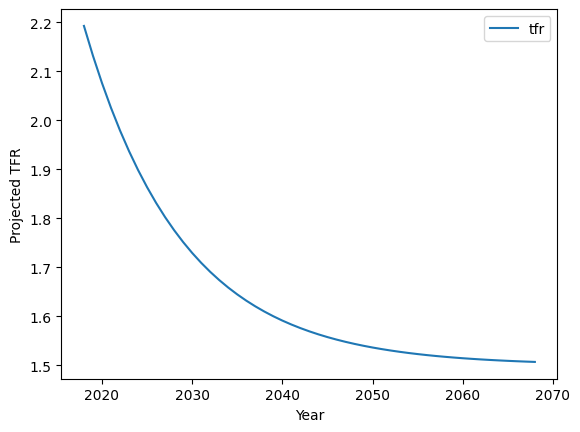

In [94]:
df_trajectory.plot('year','tfr')
plt.xlabel('Year')
plt.ylabel("Projected TFR")
plt.show()

In [103]:

def from_conteos_to_asfr(df_conteos,dpto,year): 
    
    df_birth_dpto = df_conteos[(df_conteos['ANO']==year) & 
        (df_conteos['FUENTE']=='EEVV') & 
        (df_conteos['VARIABLE']=='nacimientos') & 
        (df_conteos['DPTO_NOMBRE']==dpto)].copy()

    df_pop_dpto = df_conteos[(df_conteos['ANO']==year) & 
        (df_conteos['FUENTE']==f'censo_{year}') & 
        (df_conteos['VARIABLE']=='poblacion_total') & 
        (df_conteos['DPTO_NOMBRE']==dpto)].copy()

    df_pop_female_dpto = df_pop_dpto[df_pop_dpto['SEXO']==2.0].copy()

    # birth aggregation
    df_births_agg = df_birth_dpto.groupby('EDAD')['VALOR'].sum()
    df_births_agg = pd.DataFrame(df_births_agg).reset_index()
    df_births_agg.columns = ['EDAD','births']

    # population aggregation 
    df_pop_female_agg = df_pop_female.groupby('EDAD')['VALOR'].sum()
    df_pop_female_agg = pd.DataFrame(df_pop_female_agg).reset_index()
    df_pop_female_agg.columns = ['EDAD','population']

    # merge births and population data 
    df_fertility = pd.merge(df_births_agg, df_pop_female_agg, on='EDAD', how='inner')
    
    # get the target tfr and convergence year 
    target_file = data_path/ "target_tfrs_example.csv"
    target_dict,conv_years_dict = get_target_params(target_file)

    target_tfr = target_dict.get(dpto, 1.5) # if it doesn't exist, use 1.5 
    conv_years = conv_years_dict.get(dpto, 50)

    # calculate the baseline asfr and tfr 
    asfr_baseline = compute_asfr(ages=df_fertility['EDAD'],
                               population=df_fertility.set_index('EDAD')['population'],
                               births=df_fertility.set_index('EDAD')['births'])
                               
    baseline_tfr = _tfr_from_asfr_df(asfr_baseline)

    
    # calulate the asfr and tfr by year
    years = []
    tfr_by_years = {}
    asfr_at_step = asfr_baseline.copy()
    _
    for step in range(conv_years+1):
        tfr_at_step = _smooth_tfr(TFR0=baseline_tfr,
                                  target=target_tfr,
                                  years=conv_years,
                                  step=step,
                                  kind='exp')
        
        scaling_factor = tfr_at_step / baseline_tfr
        asfr_at_step[f'asfr_{year+step}'] = asfr_at_step['asfr']*scaling_factor
        tfr_by_years[step+year] = tfr_at_step

    return tfr_by_years,asfr_at_step
    

In [104]:
tfr_by_years,asfr_at_step = from_conteos_to_asfr(df_conteos=df,dpto=dpto,year=year)

In [105]:
tfr_by_years

{2018: 2.192793929641123,
 2019: 2.123036657208271,
 2020: 2.059417268625606,
 2021: 2.0013956966450204,
 2022: 1.9484793940822573,
 2023: 1.9002191525663803,
 2024: 1.8562052891939662,
 2025: 1.8160641687163948,
 2026: 1.779455031736958,
 2027: 1.7460671019922465,
 2028: 1.7156169481614159,
 2029: 1.6878460778076436,
 2030: 1.6625187430266555,
 2031: 1.6394199391743984,
 2032: 1.618353579684984,
 2033: 1.5991408314848699,
 2034: 1.5816185968725498,
 2035: 1.5656381289763768,
 2036: 1.5510637690370879,
 2037: 1.5377717947957819,
 2038: 1.525649370211271,
 2039: 1.5145935875909227,
 2040: 1.5045105940036023,
 2041: 1.4953147945588101,
 2042: 1.4869281257886164,
 2043: 1.4792793929641124,
 2044: 1.472303665720827,
 2045: 1.4659417268625605,
 2046: 1.460139569664502,
 2047: 1.4548479394082257,
 2048: 1.450021915256638,
 2049: 1.4456205289193966,
 2050: 1.4416064168716394,
 2051: 1.4379455031736956,
 2052: 1.4346067101992246,
 2053: 1.4315616948161416,
 2054: 1.4287846077807642,
 2055: 1.4

In [106]:
asfr_at_step

,population,births,asfr,asfr_2018,asfr_2019,asfr_2020,asfr_2021,asfr_2022,asfr_2023,asfr_2024,...,asfr_2059,asfr_2060,asfr_2061,asfr_2062,asfr_2063,asfr_2064,asfr_2065,asfr_2066,asfr_2067,asfr_2068
EDAD,,,,,,,,,,,,,,,,,,,,,
10-14,86001.0,344.0,0.004000,0.004000,0.003873,0.003757,0.003651,0.003554,0.003466,0.003386,...,0.002587,0.002584,0.002581,0.002579,0.002577,0.002575,0.002573,0.002571,0.002570,0.002568
15-19,86492.0,7219.0,0.083464,0.083464,0.080809,0.078388,0.076179,0.074165,0.072328,0.070653,...,0.053980,0.053919,0.053863,0.053813,0.053766,0.053724,0.053686,0.053651,0.053619,0.053590
20-24,82279.0,10091.0,0.122644,0.122644,0.118742,0.115184,0.111939,0.108979,0.106280,0.103818,...,0.079318,0.079229,0.079147,0.079073,0.079005,0.078943,0.078887,0.078836,0.078789,0.078746
25-29,77300.0,8323.0,0.107671,0.107671,0.104246,0.101122,0.098273,0.095675,0.093305,0.091144,...,0.069635,0.069557,0.069485,0.069420,0.069360,0.069306,0.069257,0.069211,0.069170,0.069133
30-34,70017.0,5044.0,0.072040,0.072040,0.069748,0.067658,0.065752,0.064013,0.062428,0.060982,...,0.046591,0.046538,0.046490,0.046447,0.046407,0.046371,0.046337,0.046307,0.046280,0.046255
35-39,66558.0,2542.0,0.038192,0.038192,0.036977,0.035869,0.034859,0.033937,0.033096,0.032330,...,0.024700,0.024673,0.024647,0.024624,0.024603,0.024584,0.024566,0.024550,0.024535,0.024522
40-44,57533.0,568.0,0.009873,0.009873,0.009559,0.009272,0.009011,0.008773,0.008555,0.008357,...,0.006385,0.006378,0.006371,0.006365,0.006360,0.006355,0.006350,0.006346,0.006342,0.006339
45-49,55060.0,33.0,0.000599,0.000599,0.000580,0.000563,0.000547,0.000533,0.000519,0.000507,...,0.000388,0.000387,0.000387,0.000386,0.000386,0.000386,0.000386,0.000385,0.000385,0.000385
50-54,52962.0,4.0,0.000076,0.000076,0.000073,0.000071,0.000069,0.000067,0.000065,0.000064,...,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000048


### 8. Repeat this, changing the target improvement parameters. Visualise your results. How do they change?

In [12]:
# <Your answer goes here>